In [1]:
import numpy as np
import torch
import torch.utils.data as Data
import matplotlib.pyplot as plt
import torch.nn.functional as F
from bayesian_linear import BayesLinear

In [19]:
# Bayesian Neural Network
class LR(torch.nn.Module):
    def __init__(self, n_gaussians: int=10):
        super(LR, self).__init__()
        self.n_gaussians = n_gaussians
        self.gauss_bias = torch.nn.Parameter(torch.zeros(n_gaussians))
        self.gauss_sig = torch.nn.Parameter(torch.ones(n_gaussians))
        # If bias == True then the function does not extrapolate to zero
        self.linear1 = torch.nn.Linear(n_gaussians, 1, bias=False)  
        self.exp_layer = lambda x, b, sig: torch.exp(-torch.square((x - b)/sig))
    
    def get_exp_outputs(self, x):
        if x.dim() == 2:
            x = x.expand(-1, self.n_gaussians)
        return self.exp_layer(x, self.gauss_bias, self.gauss_sig)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.expand(-1, self.n_gaussians)
        x = self.exp_layer(x, self.gauss_bias, self.gauss_sig)
        return self.linear1(x)

In [20]:
# Build data sets
def get_dset1():
    x1 = np.linspace(-10, -7, 20)
    y1 = np.ones_like(x1)
    x2 = np.linspace(-4, -2, 30)
    y2 = np.zeros_like(x2)
    x3 = np.linspace(1, 3, 20)
    y3 = np.ones_like(x3)

    X = torch.Tensor(np.concatenate([x1, x2, x3])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y2, y3]))
    return X, Y

In [21]:
X, Y = get_dset1()
model = LR()

torch_dataset = Data.TensorDataset(X, Y)
BATCH_SIZE = 30
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2)

num_epochs = 100

loss_fn = torch.nn.MSELoss()
loss_hist = []
optim = torch.optim.Adam(params=model.parameters(), lr=1e-2)

for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(loader):  # for each training step
        y_pred = model(batch_x).view(-1,)
        assert y_pred.shape == batch_y.shape
        loss = loss_fn(y_pred, batch_y)
        optim.zero_grad()
        loss.backward()
        optim.step()
    print("Epoch Nr.:", epoch, ". Loss: ", loss.item())

Epoch Nr.: 0 . Loss:  0.7007083892822266
Epoch Nr.: 1 . Loss:  0.1985650211572647
Epoch Nr.: 2 . Loss:  0.4809322953224182
Epoch Nr.: 3 . Loss:  0.5734094381332397
Epoch Nr.: 4 . Loss:  0.3634800612926483
Epoch Nr.: 5 . Loss:  0.4950471818447113
Epoch Nr.: 6 . Loss:  0.5724297761917114
Epoch Nr.: 7 . Loss:  0.6906601190567017
Epoch Nr.: 8 . Loss:  0.5161029696464539
Epoch Nr.: 9 . Loss:  0.3830873966217041
Epoch Nr.: 10 . Loss:  0.5147016644477844
Epoch Nr.: 11 . Loss:  0.5004446506500244
Epoch Nr.: 12 . Loss:  0.5951477289199829
Epoch Nr.: 13 . Loss:  0.40518730878829956
Epoch Nr.: 14 . Loss:  0.4017840325832367
Epoch Nr.: 15 . Loss:  0.2325296849012375
Epoch Nr.: 16 . Loss:  0.138917475938797
Epoch Nr.: 17 . Loss:  0.2678399682044983
Epoch Nr.: 18 . Loss:  0.5006439089775085
Epoch Nr.: 19 . Loss:  0.5281698107719421
Epoch Nr.: 20 . Loss:  0.3913052976131439
Epoch Nr.: 21 . Loss:  0.37064069509506226
Epoch Nr.: 22 . Loss:  0.4196084141731262
Epoch Nr.: 23 . Loss:  0.25765368342399597


In [26]:
def plot_fn(model, X, Y):
    x = torch.linspace(-50, 50, 300).reshape(-1, 1)
    y = model(x)
    plt.plot(x, y.detach().numpy())
    plt.scatter(X, Y)
    plt.show()
    
def plot_gaussians(model):
    x = np.linspace(-20, 20, 300)
    means = None
    sig = None
    for name, params in model.named_parameters():
        if name=='gauss_bias':
            means = params
        if name=='gauss_sig':
            sig = params
    
    for i in range(means.shape[0]):
        plt.plot(x, np.exp(-np.square((x- means[i].item())/sig[i].item())))
    plt.show()
        
        
            
            

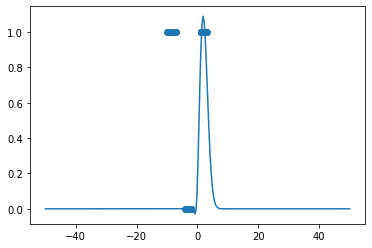

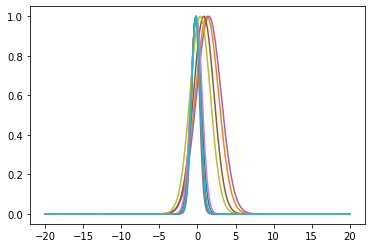

In [27]:
plot_fn(model, X, Y)
plot_gaussians(model)

In [30]:
# print(model.get_exp_outputs(torch.tensor([-1, 20]).view(-1, 1)))
for name, param in model.named_parameters():
    if name=='gauss_bias':
        print(param)
    if name=='gauss_sig':
        print(param)
        

Parameter containing:
tensor([-0.1833,  1.2513, -0.2245, -0.2258,  1.4973,  0.8232, -0.1414, -0.2657,
         0.3520, -0.2218], requires_grad=True)
Parameter containing:
tensor([0.9676, 2.1601, 0.8172, 0.8109, 2.2828, 1.9149, 1.0642, 0.7279, 1.8899,
        0.8299], requires_grad=True)
